# 03-3 모델 저장소와 전이 학습

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hm-dl/blob/main/03-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 텐서플로 허브

In [1]:
import tf_keras as keras
from tf_keras import layers
import tensorflow_hub as hub

In [2]:
hub_efficientb0 = keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Rescaling(1.0 / 255.0),
    hub.KerasLayer("https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-classification/versions/1")
])

In [3]:
!gdown 1xGkTT3uwYt4myj6eJJeYtdEFgTi2Sj8C
!unzip cat-dog-images.zip

Downloading...
From: https://drive.google.com/uc?id=1xGkTT3uwYt4myj6eJJeYtdEFgTi2Sj8C
To: /content/cat-dog-images.zip
100% 182k/182k [00:00<00:00, 7.37MB/s]
Archive:  cat-dog-images.zip
   creating: images/
  inflating: images/dog.png          
  inflating: images/cat.png          


In [4]:
import numpy as np
from PIL import Image

dog_png = np.array(Image.open('images/dog.png'))

In [5]:
from keras.applications import efficientnet

predictions = hub_efficientb0.predict(dog_png[np.newaxis,:])
efficientnet.decode_predictions(predictions)

1/1 [==============================] - 8s 8s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[[('n02099712', 'Labrador_retriever', 0.36829397),
  ('n02104029', 'kuvasz', 0.19339873),
  ('n02099601', 'golden_retriever', 0.061458185),
  ('n02111500', 'Great_Pyrenees', 0.05779695),
  ('n02095889', 'Sealyham_terrier', 0.017902765)]]

## 허깅페이스 모델 저장소

In [6]:
from transformers import pipeline

pipe = pipeline(task='image-classification', model='google/efficientnet-b0')
pipe('images/dog.png')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'Labrador retriever', 'score': 0.368294358253479},
 {'label': 'kuvasz', 'score': 0.19339904189109802},
 {'label': 'golden retriever', 'score': 0.061458274722099304},
 {'label': 'Great Pyrenees', 'score': 0.057796820998191833},
 {'label': 'Sealyham terrier, Sealyham', 'score': 0.017902739346027374}]

## 전이 학습

In [7]:
!gdown 10bnEC6-ZfXZFZ2mb3zoWd38TjYufanWo

Downloading...
From: https://drive.google.com/uc?id=10bnEC6-ZfXZFZ2mb3zoWd38TjYufanWo
To: /content/Pistachio_Image_Dataset.zip
100% 25.9M/25.9M [00:01<00:00, 21.4MB/s]


In [8]:
!unzip -q Pistachio_Image_Dataset.zip

In [9]:
pistachio_sample = np.array(Image.open('Pistachio_Image_Dataset/Kirmizi_Pistachio/kirmizi (1).jpg'))

In [10]:
pistachio_sample.shape

(600, 600, 3)

In [11]:
efficientb7 = keras.applications.EfficientNetB7()

predictions = efficientb7.predict(pistachio_sample[np.newaxis,:])
efficientnet.decode_predictions(predictions)

1/1 [==============================] - 8s 8s/step


[[('n01950731', 'sea_slug', 0.23482412),
  ('n01924916', 'flatworm', 0.20674428),
  ('n01943899', 'conch', 0.08622342),
  ('n01945685', 'slug', 0.08500538),
  ('n01955084', 'chiton', 0.028242925)]]

In [12]:
keras_efficientb0_base = keras.applications.EfficientNetB0(include_top=False)
feature_map = keras_efficientb0_base(pistachio_sample[np.newaxis,:])
feature_map.shape

16705208/16705208 [==============================] - 0s 0us/step


TensorShape([1, 18, 18, 1280])

In [13]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    'Pistachio_Image_Dataset', image_size=(224, 224), batch_size=16,
    validation_split=0.2, subset='both', seed=42
)

Found 2148 files belonging to 2 classes.
Using 1719 files for training.
Using 429 files for validation.


In [14]:
keras_efficientb0_base.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = keras_efficientb0_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

rmsprop = keras.optimizers.RMSprop(learning_rate=5e-5)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
108/108 [==============================] - 21s 117ms/step - loss: 0.4900 - accuracy: 0.8162 - val_loss: 0.3636 - val_accuracy: 0.9091
Epoch 2/20
108/108 [==============================] - 8s 67ms/step - loss: 0.3210 - accuracy: 0.9092 - val_loss: 0.2555 - val_accuracy: 0.9301
Epoch 3/20
108/108 [==============================] - 5s 44ms/step - loss: 0.2442 - accuracy: 0.9290 - val_loss: 0.2001 - val_accuracy: 0.9441
Epoch 4/20
108/108 [==============================] - 6s 57ms/step - loss: 0.1959 - accuracy: 0.9453 - val_loss: 0.1685 - val_accuracy: 0.9534
Epoch 5/20
108/108 [==============================] - 5s 48ms/step - loss: 0.1645 - accuracy: 0.9523 - val_loss: 0.1442 - val_accuracy: 0.9580
Epoch 6/20
108/108 [==============================] - 5s 45ms/step - loss: 0.1413 - accuracy: 0.9639 - val_loss: 0.1291 - val_accuracy: 0.9650
Epoch 7/20
108/108 [==============================] - 6s 55ms/step - loss: 0.1267 - accuracy: 0.9639 - val_loss: 0.1181 - val_accuracy: 0.97

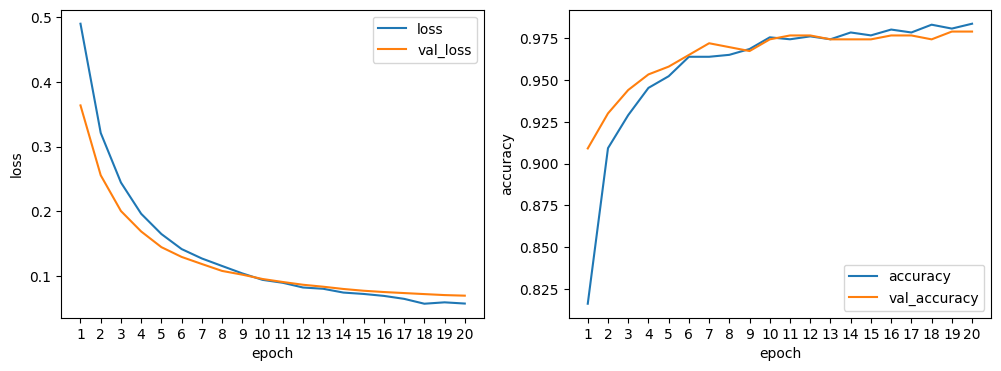

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(range(1, 21), hist.history['loss'], label='loss')
axs[0].plot(range(1, 21), hist.history['val_loss'], label='val_loss')
axs[0].set_xticks(range(1, 21))
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(range(1, 21), hist.history['accuracy'], label='accuracy')
axs[1].plot(range(1, 21), hist.history['val_accuracy'], label='val_accuracy')
axs[1].set_xticks(range(1, 21))
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.show()

## 심화 학습

In [16]:
kaggle_efficientb0_base = hub.KerasLayer('https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1')

inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1.0 / 255.0)(inputs)
x = kaggle_efficientb0_base(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [17]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
108/108 [==============================] - 16s 60ms/step - loss: 0.3523 - accuracy: 0.8802 - val_loss: 0.2208 - val_accuracy: 0.9371
Epoch 2/20
108/108 [==============================] - 5s 46ms/step - loss: 0.1843 - accuracy: 0.9482 - val_loss: 0.1458 - val_accuracy: 0.9580
Epoch 3/20
108/108 [==============================] - 5s 43ms/step - loss: 0.1311 - accuracy: 0.9657 - val_loss: 0.1181 - val_accuracy: 0.9720
Epoch 4/20
108/108 [==============================] - 5s 42ms/step - loss: 0.1036 - accuracy: 0.9721 - val_loss: 0.1174 - val_accuracy: 0.9627
Epoch 5/20
108/108 [==============================] - 6s 55ms/step - loss: 0.0870 - accuracy: 0.9709 - val_loss: 0.0996 - val_accuracy: 0.9650
Epoch 6/20
108/108 [==============================] - 5s 43ms/step - loss: 0.0739 - accuracy: 0.9796 - val_loss: 0.0849 - val_accuracy: 0.9767
Epoch 7/20
108/108 [==============================] - 5s 45ms/step - loss: 0.0655 - accuracy: 0.9808 - val_loss: 0.0762 - val_accuracy: 0.976

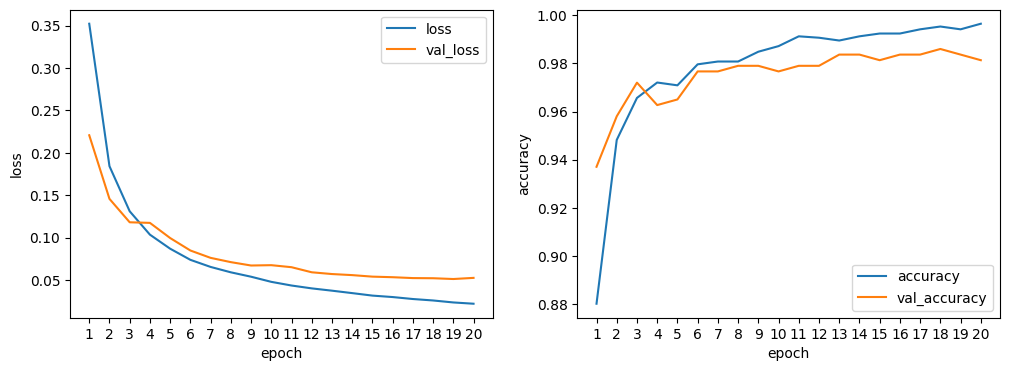

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(range(1, 21), hist.history['loss'], label='loss')
axs[0].plot(range(1, 21), hist.history['val_loss'], label='val_loss')
axs[0].set_xticks(range(1, 21))
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(range(1, 21), hist.history['accuracy'], label='accuracy')
axs[1].plot(range(1, 21), hist.history['val_accuracy'], label='val_accuracy')
axs[1].set_xticks(range(1, 21))
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.show()